# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [ ]:
!pip install --upgrade gspread

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow
import requests
from sklearn.preprocessing import MinMaxScaler
from google.colab import auth
from io import BytesIO
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
%matplotlib inline

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load data through google sheets due to tensorflow issues on local machine
gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('Homework_14_sentiment').sheet1
rows = worksheet.get_all_values()

df = pd.DataFrame.from_records(rows)
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.drop(columns="fng_classification")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [12]:
# Load the historical closing prices for Bitcoin
worksheet2 = gc.open('Homework_14_historic').sheet1
rows2 = worksheet2.get_all_values()
df2 = pd.DataFrame.from_records(rows2)
new_header2 = df2.iloc[0]
df2 = df2[1:] 
df2.columns = new_header2
df2['Date'] = pd.to_datetime(df2['Date'])
df2.set_index('Date', inplace=True)
df2 = df2.drop(columns=['Open','High', 'Low', 'Adj Close', 'Volume'])
df2.head()

,Close
Date,
2018-01-02,14754.12988
2018-01-03,15156.62012
2018-01-04,15180.08008
2018-01-05,16954.7793
2018-01-06,17172.30078


In [13]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [14]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [29]:
# Predict Closing Prices using a 10 day window of fear and greed index values and a target of the 11th day closing price
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 6

# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [30]:
# Use 70% of the data for training and the remainder for testing
# YOUR CODE HERE!
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [31]:
# Use MinMaxScaler to scale the data between 0 and 1. 
# YOUR CODE HERE!
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [32]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [33]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# YOUR CODE HERE!
model = Sequential()
number_units = 30
dropout_fraction = 0.2

model.add(LSTM(
            units=number_units,
            return_sequences=True,
            input_shape=(X_train.shape[1], 1))
        )
model.add(Dropout(dropout_fraction))

# Add Another Layer

model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Add Another Layer

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


model.add(Dense(1))

In [34]:
# Compile the model
# YOUR CODE HERE!
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
# Summarize the model
# YOUR CODE HERE!
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 6, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 30)             7320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 30)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [36]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
model.fit(X_train, y_train, epochs=15, shuffle=False, batch_size=2, verbose=1)

Epoch 1/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0371
Epoch 2/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0346
Epoch 3/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0319
Epoch 4/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0327
Epoch 5/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0336
Epoch 6/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0325
Epoch 7/15
175/175 [==============================] - 1s 9ms/step - loss: 0.0313
Epoch 8/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0319
Epoch 9/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0310
Epoch 10/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0314
Epoch 11/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0305
Epoch 12/15
175/175 [==============================] - 1s 8ms/step - loss: 0.0310
Epoch 13/15
175/175 [====

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [37]:
# Evaluate the model
# YOUR CODE HERE!
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.0531


0.05305277556180954

In [38]:
# Make some predictions
# YOUR CODE HERE!
predicted = model.predict(X_test)

In [39]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [40]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3467.209961,5351.622559
1,3434.129883,5225.682129
2,3461.629883,5042.743164
3,3508.679932,4916.411133
4,3449.620117,4839.458008


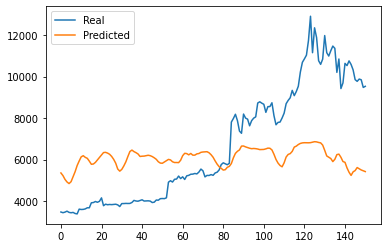

In [41]:
# Plot the real vs predicted values as a line chart
# YOUR CODE HERE!
stocks.plot()

In [ ]:
#That does not appear very accurate to me